In [6]:
from loaders.eigenfaces_loader import EigenfacesDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
eigenfaces = EigenfacesDataset(dir='/Users/jaq/Documents/HAM10000_EECS504/archive')
X, y = eigenfaces.collect_images()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
pca = PCA(n_components=150) # fit pca to training data (find eigenfaces)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [9]:
params = [{'kernel':['rbf', 'poly'], 'C':[1, 5, 10], 'gamma': ['scale', 'auto']}]
clf_pipe = svm.SVC()
gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_clf.fit(X_train_pca, y_train)
print(gs_clf.best_params_)

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


In [11]:
# Run classification of test images based on pca / svm model, returns accuracy on last line
clf = svm.SVC(C=5, kernel='rbf', gamma='scale')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
np.where(y_pred - y_test ==0)[0].shape[0] / y_test.shape[0]

0.7493759360958562

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


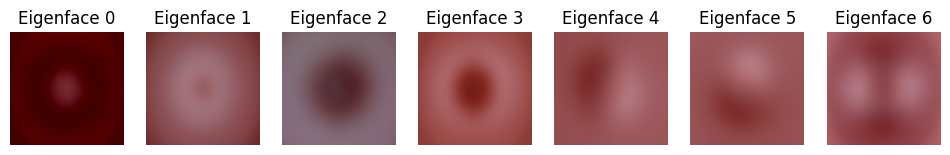

In [13]:
def rescale_eigenval(mean, component, img_shape):
    '''
    The eigenvalues returned by pca component are scaled to unit variance. This function rescales them to the mean range of image set.
    Inputs: mean (mean image), component (a component of pca.components_), img_shape (shape of image)
    Output: color-rescaled pca component
    '''
    mean = mean.reshape(img_shape)
    red = mean[:,:,0]
    green = mean[:,:,1]
    blue = mean[:,:,2]

    red_range = np.max(red) - np.min(red)
    green_range = np.max(green) - np.min(green)
    blue_range = np.max(blue) - np.min(blue)
    component = component.reshape(img_shape)
    
    r = component[:,:,0]
    g = component[:,:,1]
    b = component[:,:,2]

    new_r = r * red_range/(np.max(r) - np.min(r)) + np.min(red)
    new_g = g * green_range/(np.max(g) - np.min(g)) + np.min(green)
    new_b = b * blue_range/(np.max(b) - np.min(b)) + np.min(blue)
    return np.stack([new_r, new_g, new_b], axis=2)

### plot first 7 eigenfaces
fig, ax = plt.subplots(figsize=(12,2), ncols=7, nrows=1)
for i in range(7):
    image = pca.components_[i].reshape((224,224,3))
    inp = rescale_eigenval(pca.mean_, image, (224,224,3))
    ax[i].imshow(inp)
    ax[i].axis("off") 
    ax[i].set_title(f'Eigenface {i}')
plt.show()

Text(0, 0.5, 'Model Accuracy')

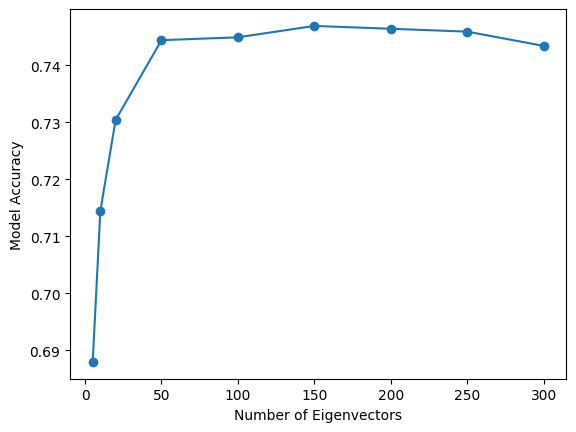

In [14]:
n = [5, 10, 20, 50, 100, 150, 200, 250, 300]
acc = []
for i in n:
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf = svm.SVC(C=5, kernel='rbf', gamma='scale')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc.append(np.where(y_pred - y_test ==0)[0].shape[0] / y_test.shape[0])

plt.plot(n, acc, marker='o')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Model Accuracy')